In [1]:
from krasulina import KrasulinaPCA, get_random_orthogonal_initializer, get_eigenvecs
from vr_pca import VRPCA, get_default_learning_rate
from oja import Oja
import numpy as np
import math

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## VGG data
* script adapted from <https://github.com/cmusatyalab/openface/blob/master/data/vgg/download-and-align.py>

In [2]:
import os
import cv2

def load_vgg(path_to_images):
    tot_n_images = 0
    for (dirpath, _, _) in os.walk(path_to_images):
        tot_n_images += len(os.listdir(dirpath))
    print(f"Total number of aligned images is {tot_n_images}")
    img_data = []
    for (dirname, _, filenames) in os.walk(path_to_images):
        for im in filenames:
            im_path = os.path.join(dirname, im)
            grey_img = cv2.imread(im_path, 0)
            img_data.append(grey_img.flatten())
    dataset = np.stack(img_data, axis=0)
    return dataset

In [3]:
vgg_data = load_vgg('aligned')

Total number of aligned images is 10826


In [5]:
vgg_data.shape

(10806, 2304)

In [6]:
n_samples, n_features = vgg_data.shape
# global centering
vgg_centered = vgg_data - vgg_data.mean(axis=0)

In [7]:
from sklearn import decomposition

#pca = decomposition.PCA(n_components=0.8, svd_solver='full')
pca = decomposition.PCA(svd_solver='full')

In [8]:
pca.fit(vgg_centered)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

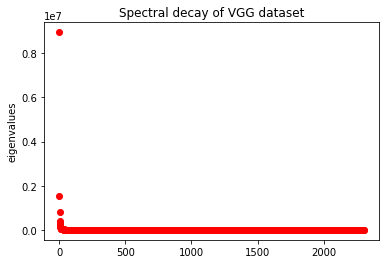

In [9]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

plt.plot(list(range(pca.n_components_)), pca.explained_variance_, 'ro')
plt.ylabel('eigenvalues')
plt.title('Spectral decay of VGG dataset')
plt.savefig('vgg_spectrum.png', dpi=300)

In [ ]:
print('Number of used components', pca.n_components_)
print('Largest eigenvalue: {}, smallest eigenvalue {}'.format(pca.explained_variance_[0], pca.explained_variance_[-1]))

In [ ]:
k = 6
d = n_features
_init_weights = get_random_orthogonal_initializer(k, d, seed=0)

n_train = len(vgg_centered)

n_runs = 5

In [ ]:
# mb_size = 1
# T = int(n_train / float(mb_size))

# lr = (None, 5*1e-09) 
# log_freq = int(T / 10.0)
# algo = KrasulinaPCA(_init_weights, vgg_centered, groundtruth=pca.components_, 
#                     learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)

In [ ]:
#algo._train()

In [ ]:
import random
#random.seed(0)


algo_list = []
vr_algo_list = []
oja_decay_list = []
oja_const_list = []
#random.shuffle(vgg_centered)

In [ ]:
for i in range(n_runs):
    vgg_centered_2 = vgg_centered.copy()
    random.seed(i)
    random.shuffle(vgg_centered_2)
    mb_size = 1
    T = 4*int(n_train / float(mb_size))
    lr = (None, 3*1e-09) 
    #lr = (None, 1e-08) 
    #lr = (1e-05, 1)
    log_freq = int(T / 10.0)
    algo = KrasulinaPCA(_init_weights, vgg_centered_2, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)
    algo._train()
    algo_list.append(algo)

In [ ]:
# n_epoch = 2
# #lr = get_default_learning_rate(vgg_centered)
# lr = 1e-09 * 5
# #lr = 1e-09
# #lr = (0.001, 10)
# vr_algo = VRPCA(_init_weights, vgg_centered, pca.components_, lr, n_train, 
#                 n_epoch, log_freq=n_epoch*int(n_train/10.0))

In [ ]:
#vr_algo._train()

In [ ]:
for i in range(n_runs):
    vgg_centered_2 = vgg_centered.copy()
    random.seed(i)
    random.shuffle(vgg_centered_2)
    n_epoch = 2
    #lr = get_default_learning_rate(vgg_centered)
    #lr = 1e-09 * 3
    lr = 1e-08
    vr_algo = VRPCA(_init_weights, vgg_centered_2, pca.components_, lr, n_train, 
                n_epoch, log_freq=n_epoch*int(n_train/10.0))
    vr_algo._train()
    vr_algo_list.append(vr_algo)

In [ ]:
vr_algo_default_list = []
for i in range(n_runs):
    vgg_centered_2 = vgg_centered.copy()
    random.seed(i)
    random.shuffle(vgg_centered_2)
    n_epoch = 2
    lr = get_default_learning_rate(vgg_centered)
    #lr = 1e-08  
    vr_algo_default = VRPCA(_init_weights, vgg_centered_2, pca.components_, lr, n_train, 
                n_epoch, log_freq=n_epoch*int(n_train/10.0))
    vr_algo_default._train()
    vr_algo_default_list.append(vr_algo_default)

In [ ]:
# for _ in range(n_runs):
#     mb_size = 1
#     T = 1*int(n_train / float(mb_size))
#     lr = (1e-4, 1)
#     log_freq = int(T / 10.0)
#     oja_algo = Oja(_init_weights, vgg_centered, groundtruth=pca.components_, 
#                     learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)
#     oja_algo._train()
#     oja_decay_list.append(oja_algo)
    

In [ ]:
# for _ in range(n_runs):
#     mb_size = 1
#     T = 4*int(n_train / float(mb_size))
#     lr = (None, 1e-09*3)
#     #lr = (None, 1e-09)
#     log_freq = int(T / 10.0)
#     oja_algo_ = Oja(_init_weights, vgg_centered, groundtruth=pca.components_, 
#                     learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)
#     oja_algo_._train()
#     oja_const_list.append(oja_algo_)
    

In [ ]:
eps = 1e-10

log_algo_list = []
for algo in algo_list:
    log_algo_list.append([math.log(y+eps) for y in algo._groundtruth_eval_log])

algo_mean, algo_var = np.mean(np.array(log_algo_list), axis=0), np.var(np.array(log_algo_list), axis=0)

##
log_vr_algo_list = []
for vr_algo in vr_algo_list:
    log_vr_algo_list.append([math.log(y+eps) for y in vr_algo._train_log])

vr_algo_mean, vr_algo_var = np.mean(np.array(log_vr_algo_list), axis=0), np.var(np.array(log_vr_algo_list), axis=0)

##
log_vr_algo_df_list = []
for vr_algo in vr_algo_default_list:
    log_vr_algo_df_list.append([math.log(y+eps) for y in vr_algo._train_log])

vr_algo_df_mean, vr_algo_df_var = np.mean(np.array(log_vr_algo_df_list), axis=0), np.var(np.array(log_vr_algo_df_list), axis=0)



##
# log_oja_decay_list = []
# for oja_decay in oja_decay_list:
#     log_oja_decay_list.append([math.log(y+eps) for y in oja_decay._groundtruth_eval_log])

# oja_decay_mean, oja_decay_var = np.mean(np.array(log_oja_decay_list), axis=0), np.var(np.array(log_oja_decay_list), axis=0)


##
# log_oja_const_list = []
# for oja_const in oja_const_list:
#     log_oja_const_list.append([math.log(y+eps) for y in oja_const._groundtruth_eval_log])

# oja_const_mean, oja_const_var = np.mean(np.array(log_oja_const_list), axis=0), np.var(np.array(log_oja_const_list),axis=0)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
frac_epoch = [0] + [0.1*t*4 for t in range(1, 11)]
#vrpca_frac_epoch = [1 + t for t in frac_epoch]
vrpca_frac_epoch = [0] + [1.2, 1.4, 1.6, 1.8, 2, 3, 3.2, 3.4, 3.6, 3.8, 4]

In [ ]:
plt.errorbar(frac_epoch, algo_mean, algo_var, marker='o', label='krasulina')
#plt.plot(frac_epoch, oja_decay_mean[1:], '--*', label=r'oja')
#plt.plot(frac_epoch, oja_const_mean[1:], '--s', label=r'oja-$\eta$: constant')
plt.errorbar(vrpca_frac_epoch, vr_algo_mean, vr_algo_var, marker='s', label='vr-pca')
#plt.errorbar(vrpca_frac_epoch, vr_algo_df_mean, vr_algo_df_var, label='vr-pca: default $\eta$')
plt.axvline(x=1, color='r', linestyle='--')
plt.legend()
plt.xlabel('number of data passes')
plt.ylabel('log-loss')
plt.title('VGG data')
plt.savefig('vgg_4_passes-cut.png')

In [ ]:
arr = [1,2,3]
arr[:2]